## Data generator example
---

Example showing how to create a PyTorch compatible generator which windows trace data and applies standard data augmentation steps. 

Data generation API also uses function-based decorators to allow user to easily construct data augmentation and processing pipelines. Example usage is also shown below.

***Current version of the data generator code is incomplete and subject to change**

In [1]:
import sys
import os

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seisbench.data
import numpy as np

Get dummy dataset:

In [2]:
dummy = seisbench.data.DummyDataset()
print(dummy)

DummyDataset - 100 traces


Create training/label example generator object.

In [3]:
from seisbench.util.generate import GenericGenerator

generator = GenericGenerator(dataset=dummy)
generator

Apply some simple processing steps. The ```GenericGenerator``` instance takes a single argument _dataset_ (a SeisBench dataset), and makes it compatible with and inherit the functionality a PyTorch Dataset object. This allows you to wrap the GenericGenerator in a PyTorch DataLoader the same as any other PyTorch Dataset class - giving multiprocessing, batch-loading, shuffling functionality.

Internally, ```GenericGenerator``` also ensures any processing methods applied are tracked through the objects state. Processing operations are applied recursively when __getitem__ is called. All users' need to do is decorate their processing methods with ```@generator.augmentation``` 

Below we add some standard processing steps to apply to the raw waveform data. For each processing step, the method modifies the _state_dict_ which is naturally a dictionary of the current objects state up untill this point. We add a huge offset to the demean method to easily see whether processing methods are working.


In [4]:
@generator.augmentation
def demean(state_dict, l=786876):
    state_dict['waveforms'] -= (np.mean(state_dict['waveforms']) + l)

@generator.augmentation
def create_windows(state_dict, windowlen=600, timestep=200):
    """
    Create N sequential windows from trace data.
    """
    n_windows = (state_dict['waveforms'].shape[1] - windowlen) // timestep
    X_windows = []
    y_windows = []
    # Reset window start idxs
    window_starts = (
        np.array([i for i in range(n_windows)]) * timestep
    )
    for i in range(n_windows):
        # Data is transformed to [N, C, W]
        X_windows.append(
            state_dict['waveforms'].T[i * timestep : i * timestep + windowlen].T
        )
        y_windows.append(
            state_dict['waveforms'].T[i * timestep : i * timestep + windowlen].T
        )
    # Add sequential windows to state_dict
    state_dict['X'] = np.array(X_windows)
    state_dict['y'] = np.array(y_windows)


#@generator.augmentation    
# def normalize(state_dict, norm_type="window"):
#     """
#     Normalize training examples.
#     """
#     if "norm_type" == "window":
#         state_dict['X'] = np.array(
#             [window / np.amax(window) for window in state_dict['X']], dtype=float
#         )
#     elif "norm_type" == "std":
#         state_dict['X'] = np.array(
#             [window / np.std(window) for window in state_dict['X']], dtype=float
#         )

As dicussed, wrap dataset in PyTorch DataLoader yielding batches of 5 example waveforms each time. Each example will have processing steps applied (so should be 600 sample windows, stepped along).

In [10]:
# Wrap generator in PyTorch DataLoader
train_loader = torch.utils.data.DataLoader(
    dataset=generator, 
    batch_size=5, 
    pin_memory=True, 
    shuffle=False
)

Each call of ```__getitem__``` adds training and label data to the state_dict which is then returned upon each iteration of the dataloader. 

In [11]:
for train_data in train_loader:
    break

train_data.keys()

dict_keys(['waveforms', 'metadata', 'X', 'y'])

You can also see what processing methods were applied directly in the GenericGenerator

In [7]:
import pprint

pprint.pprint(generator._augmentations, indent=2)

OrderedDict([ ( 'demean',
                { 'func': <function demean at 0x7fa5733cf830>,
                  'params': {'l': 786876}}),
              ( 'create_windows',
                { 'func': <function create_windows at 0x7fa5733cfa70>,
                  'params': {'timestep': 200, 'windowlen': 600}})])


Compress along batch dimension for plotting...

In [12]:
def compress_batch_dim(t):
    """
    Utility function to stack tensor data along batch dim.
    :param t: tensor, format (B, N, W, C)
    :type t: torch.Tensor
    :return : t: tensor, format (N, C, W)
    """
    return t.reshape(-1, t.shape[2], t.shape[3])


for train_data in train_loader:
    print('PyTorch DataLoader format:\n\t[B, N, C, W]\n')
    print('-->', train_data['X'].shape)
    
    train_data['X'] = compress_batch_dim(train_data['X'])
    print('\nCompressed windows along batch dim (now [N, C, W])\n')
    print('-->', train_data['X'].shape)
    break

PyTorch DataLoader format:
	[B, N, C, W]

--> torch.Size([5, 3, 3, 600])

Compressed windows along batch dim (now [N, C, W])

--> torch.Size([15, 3, 600])


Plot all training examples (no processing applied to windowed traces)

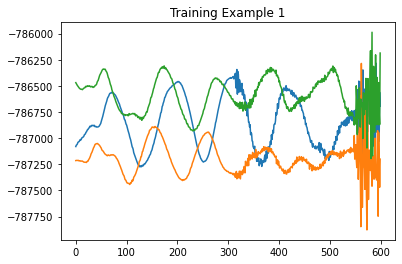

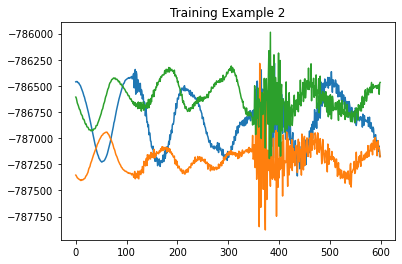

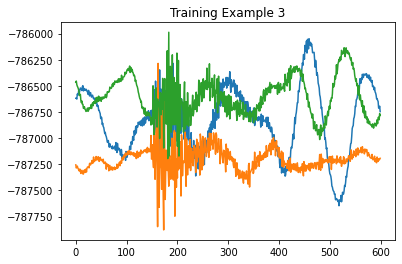

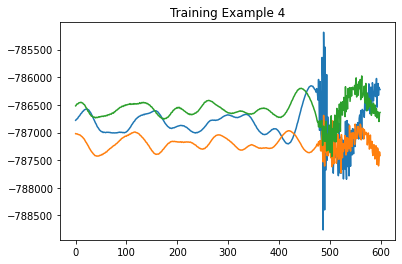

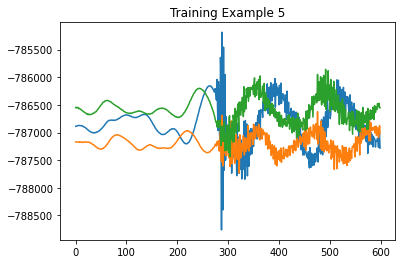

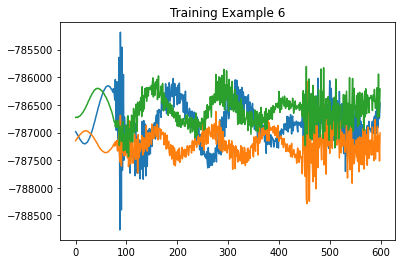

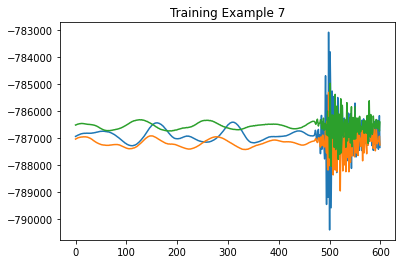

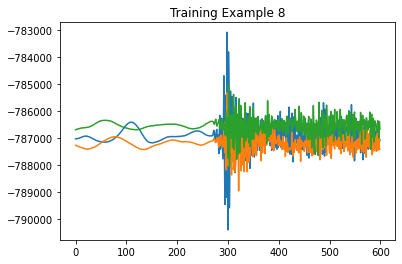

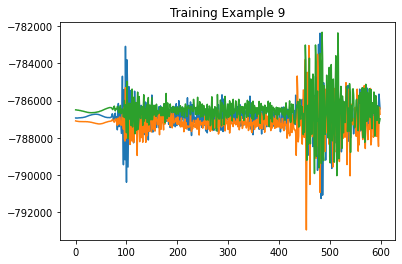

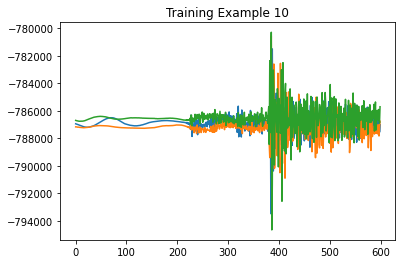

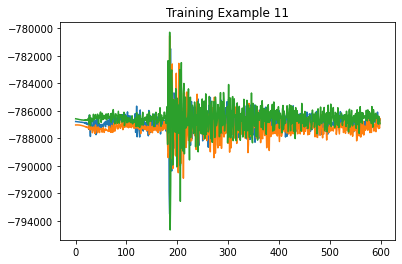

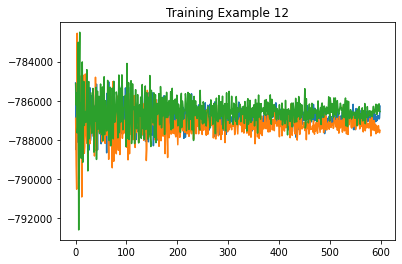

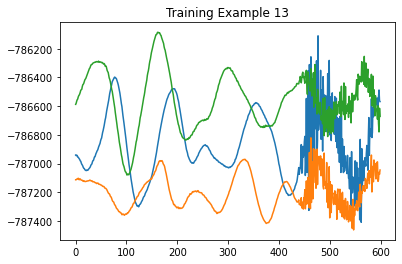

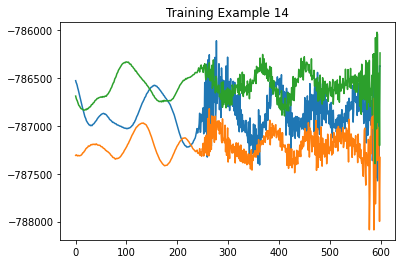

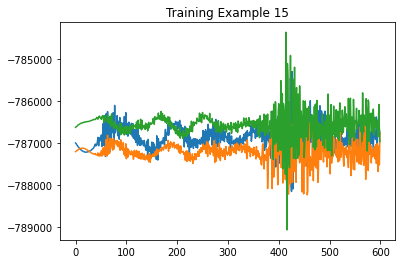

In [13]:
for i, window in enumerate(train_data['X']):
    plt.title(f'Training Example {i+1}')
    plt.plot(window.T)
    plt.show()